In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'C:\Users\Admin\OneDrive\Área de Trabalho\Ciência de Dados\data\2004-2021.csv').sort_index()
import matplotlib.pyplot as plt 

In [2]:
df = df[df['ESTADO'] == 'PARANA']
df = df[df['PRODUTO'] == 'GASOLINA COMUM']

df = df.loc[:,["DATA INICIAL", "PREÇO MÉDIO REVENDA"]]
df.columns = ['DATA', 'PREÇO']
df["DATA"] = pd.to_datetime(df["DATA"])
df

,DATA,PREÇO
12088,2004-05-09,1.966
12115,2004-05-16,1.961
12142,2004-05-23,1.963
12169,2004-05-30,1.993
12196,2004-06-06,2.001
...,...,...
120000,2021-03-28,5.227
120178,2021-04-04,5.161
120357,2021-04-11,5.176
120535,2021-04-18,5.225


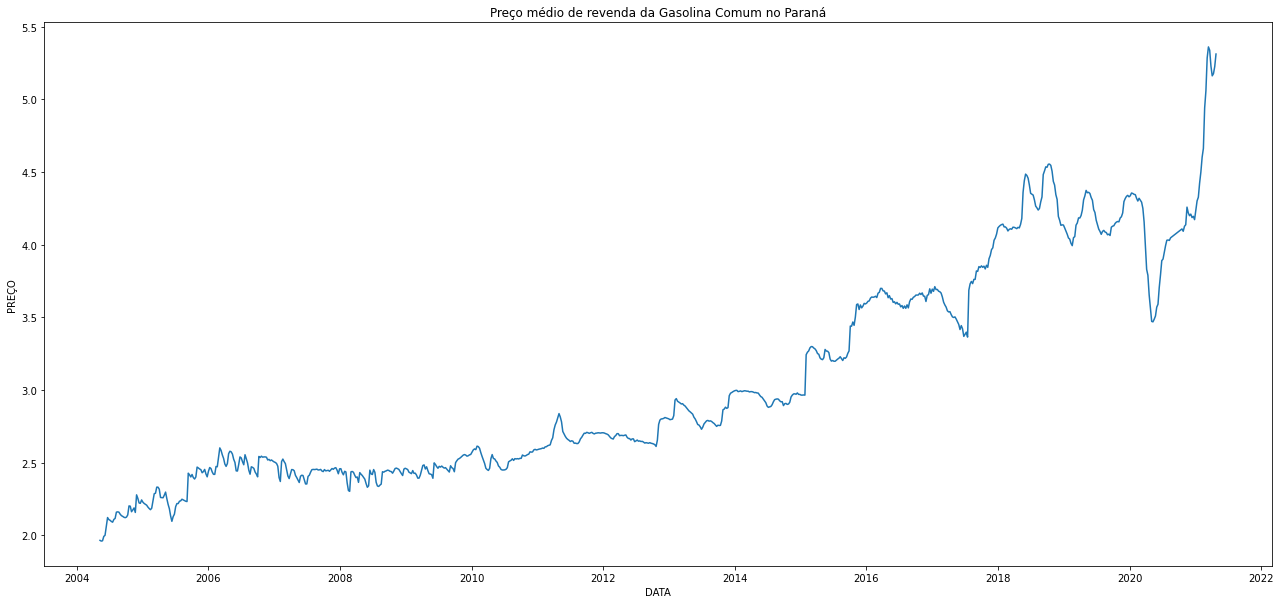

In [3]:
plt.figure(figsize=(22,10))
plt.plot(df.DATA,df.PREÇO)
plt.title("Preço médio de revenda da Gasolina Comum no Paraná")
plt.xlabel("DATA")
plt.ylabel("PREÇO")
plt.show()

In [4]:
timeSeries = df.loc[:, ["DATA","PREÇO"]]
timeSeries.index = timeSeries.DATA
ts = timeSeries.drop("DATA",axis=1)

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

In [7]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='MEDIA DO PREÇO')
    std = plt.plot(rolstd, color='green', label = 'DESVIO PADRAO DO PREÇO')
    plt.xlabel("DATA")
    plt.ylabel("PREÇO")
    plt.title("PREÇO DA GASOLINA COMUM NO PARANÁ A PARTIR DE JUNHO DE 2018")
    plt.legend()
    plt.show()

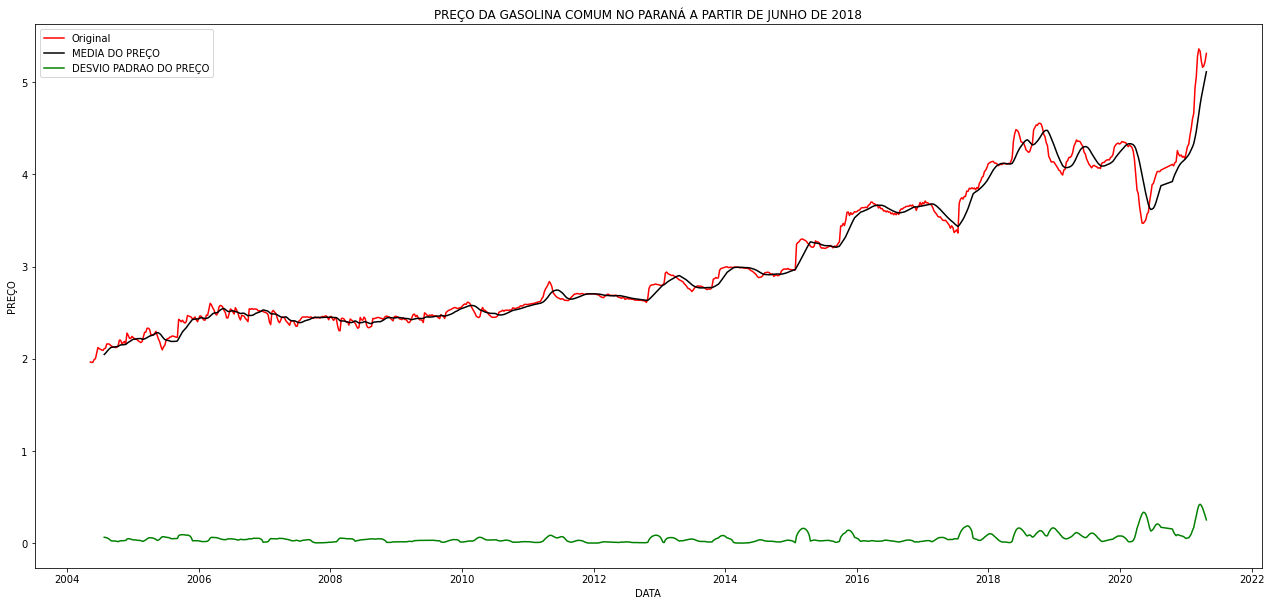

Test statistic:  0.3948975388242575
p-value:  0.9813031221741958
Critical Values: {'1%': -3.437888734710396, '5%': -2.8648678385823603, '10%': -2.5685419870524506}


In [8]:
check_mean_std(ts)
check_adfuller(ts.PREÇO)

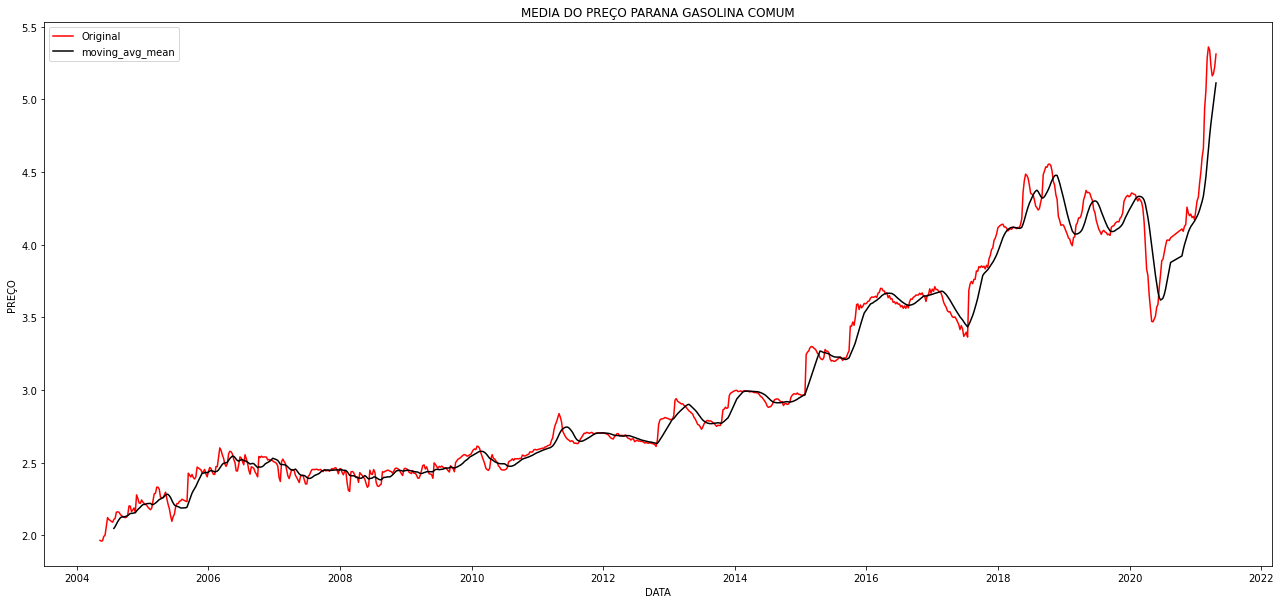

In [9]:
window_size = 6
moving_avg = ts.rolling(12).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("MEDIA DO PREÇO PARANA GASOLINA COMUM")
plt.xlabel("DATA")
plt.ylabel("PREÇO")
plt.legend()
plt.show()

In [10]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) 

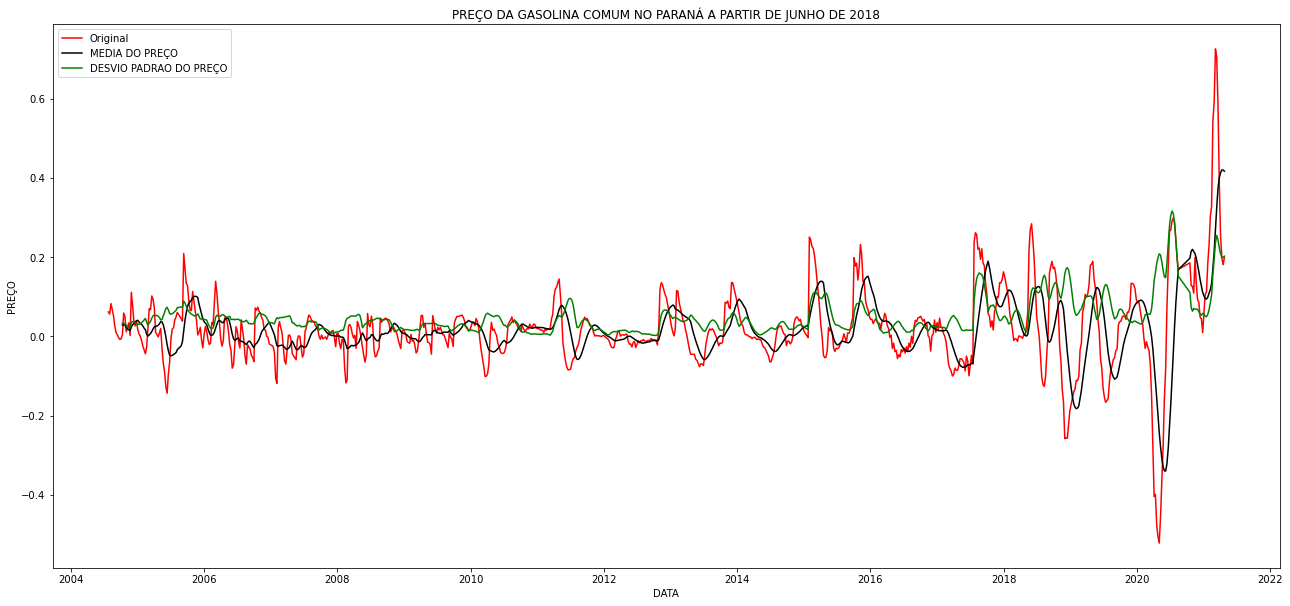

Test statistic:  -8.75950510885199
p-value:  2.6980681786868138e-14
Critical Values: {'1%': -3.438003436504483, '5%': -2.864918407242872, '10%': -2.5685689238190808}


In [11]:
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.PREÇO)

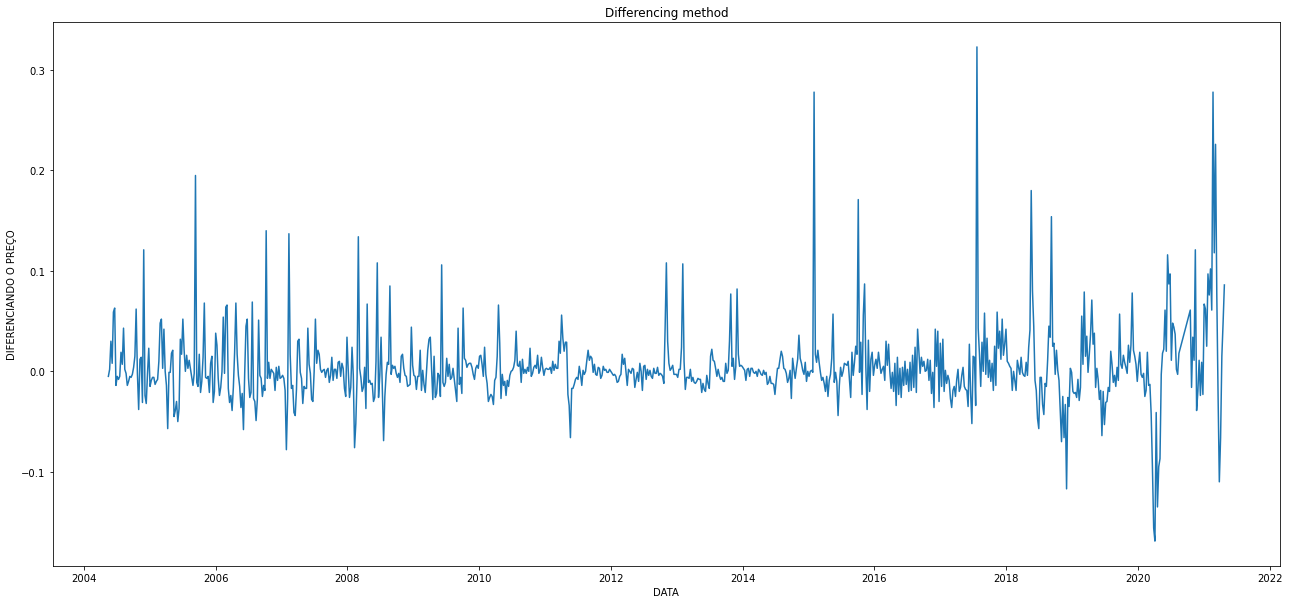

In [12]:
# método de diferenciação
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("DATA")
plt.ylabel("DIFERENCIANDO O PREÇO")
plt.show()

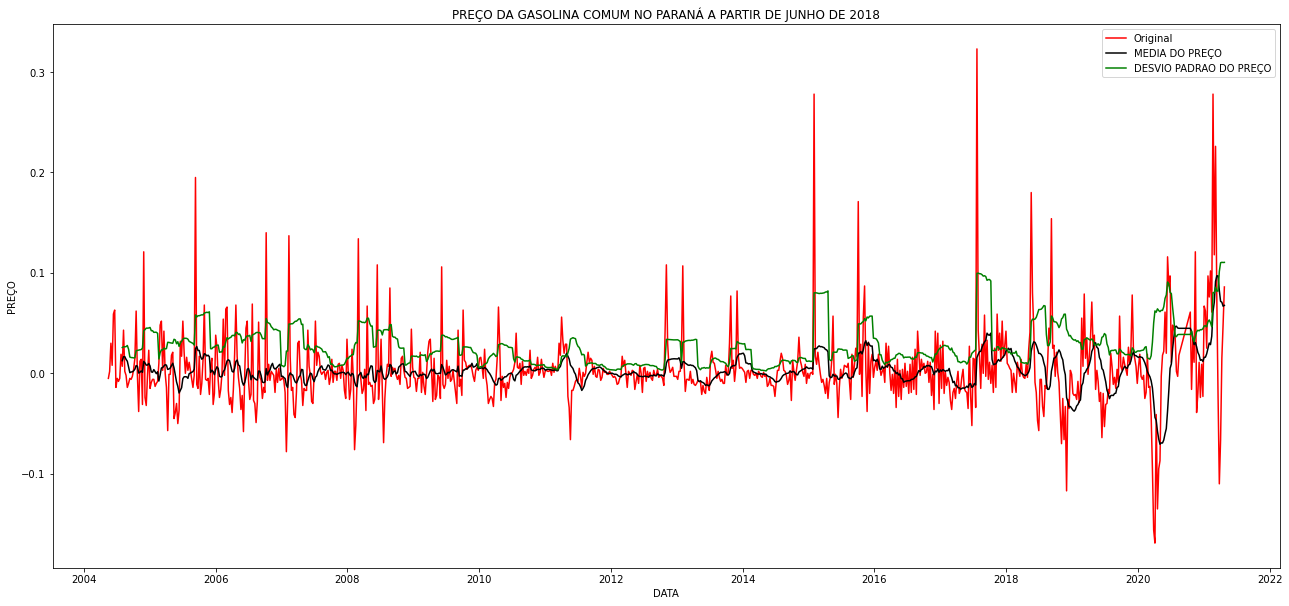

Test statistic:  -14.563969248507052
p-value:  4.7448138558506316e-27
Critical Values: {'1%': -3.437888734710396, '5%': -2.8648678385823603, '10%': -2.5685419870524506}


In [13]:
ts_diff.dropna(inplace=True) 
# verifique estacionário: média, variância (std) e teste de adfuller
check_mean_std(ts_diff)
check_adfuller(ts_diff.PREÇO)

In [14]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

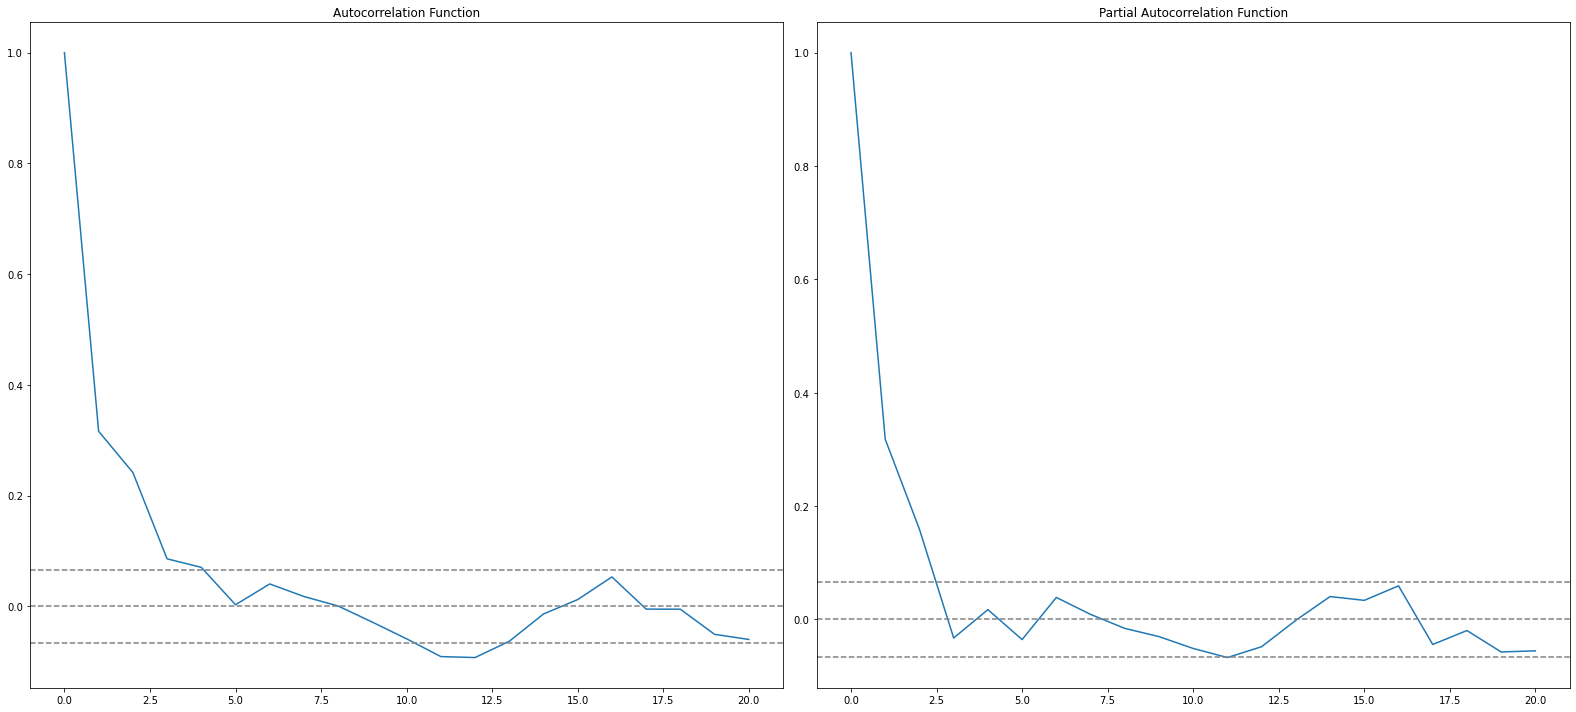

In [15]:
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Admin\AppData\Local\Temp\ipykernel_3420\278815842.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C

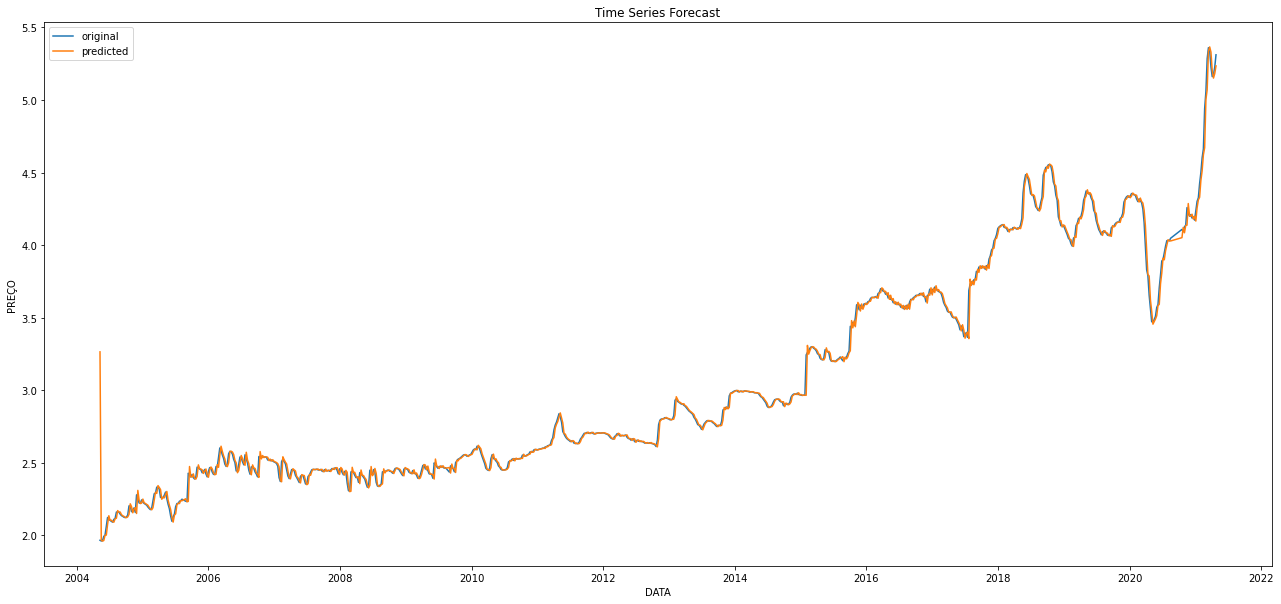

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime


# fit model
model = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()

# Preditivo (previsão)
start_index = datetime(2004, 5, 9)
end_index = datetime(2021, 4, 25)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualização
plt.figure(figsize=(22,10))
plt.plot(df.DATA,df.PREÇO,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("DATA")
plt.ylabel("PREÇO")
plt.legend()
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

error:  0.0032281850385360296


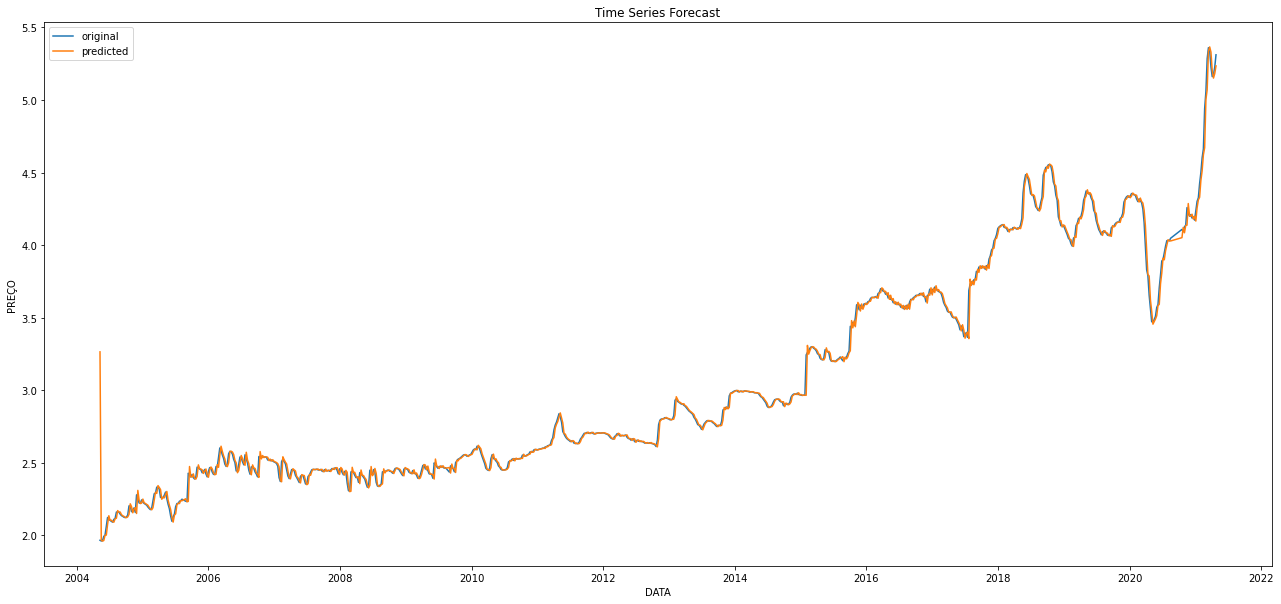

In [156]:
# prever todo o caminho
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(ts, forecast2)
print("error: " ,error)
# visualização
plt.figure(figsize=(22,10))
plt.plot(df.DATA,df.PREÇO,label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("DATA")
plt.ylabel("PREÇO")
plt.legend()
plt.savefig('graph.png')

plt.show()